In [24]:

import pandas as pd
import numpy as np
import os

#import data
from biom import load_table
from gneiss.util import match
#deicode
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr
from deicode.ratios import log_ratios
#skbio
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist
from skbio.stats.distance import permanova
from skbio.stats.composition import clr,centralize
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
import matplotlib.colors as mcolors
plt.style.use('seaborn-paper')
plt.rcParams["axes.labelsize"] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

%matplotlib inline

In [25]:
both_perm_res={}
both_perm_res['AG']=pd.read_csv('subsample_results/AG_types_of_plants_fstat.csv', index_col=[0,1,2])
both_perm_res['Sponges']=pd.read_csv('subsample_results/Sponges_health_status_fstat.csv', index_col=[0,1,2])
both_perm_res['Sleep_Apnea']=pd.read_csv('subsample_results/Sleep_Apnea_exposure_type_fstat.csv', index_col=[0,1,2])

both_nn={}
both_nn['AG']=pd.read_csv('subsample_results/AG_types_of_plants_classifier.csv', index_col=[0,1,2])
both_nn['Sponges']=pd.read_csv('subsample_results/Sponges_health_status_classifier.csv', index_col=[0,1,2])
both_nn['Sleep_Apnea']=pd.read_csv('subsample_results/Sleep_Apnea_exposure_type_classifier.csv', index_col=[0,1,2])



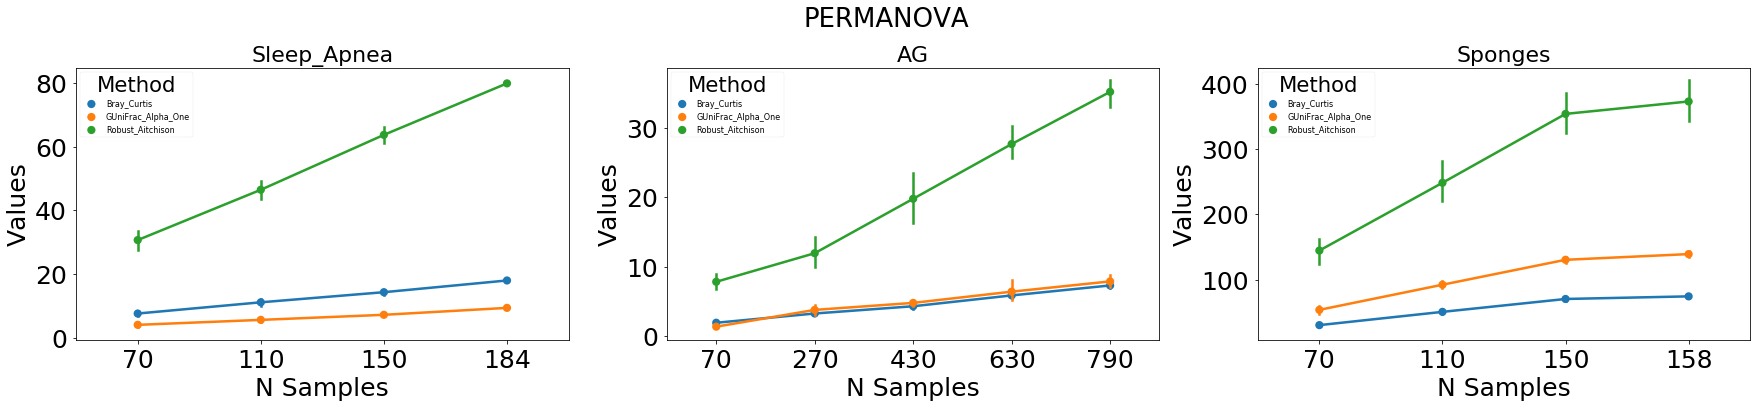

In [30]:
fig,axn=plt.subplots(1,3,figsize=(30,5))

for (dataset_,results_permanova),ax_ in zip(both_perm_res.items(),axn.flat):
    results_permanova_plot=pd.DataFrame(results_permanova.copy().stack())
    results_permanova_plot.reset_index(inplace=True)
    results_permanova_plot.columns=['Fold','N Samples','Metric','Method','Values']
    results_permanova_plot_=results_permanova_plot[results_permanova_plot.Metric.isin(['test statistic'])].copy()
    sns.pointplot(x='N Samples',y='Values',hue='Method',data=results_permanova_plot_,ax=ax_)
    ax_.set_title(dataset_,fontsize=22)
    #ax_.set_yscale('log')
    #ax_.set_xscale('log')
    #ax_.set_xlim(30,)
    #ax_.set_ylim(0,.05)
plt.suptitle('PERMANOVA',fontsize=26,y=1.05)
plt.show()



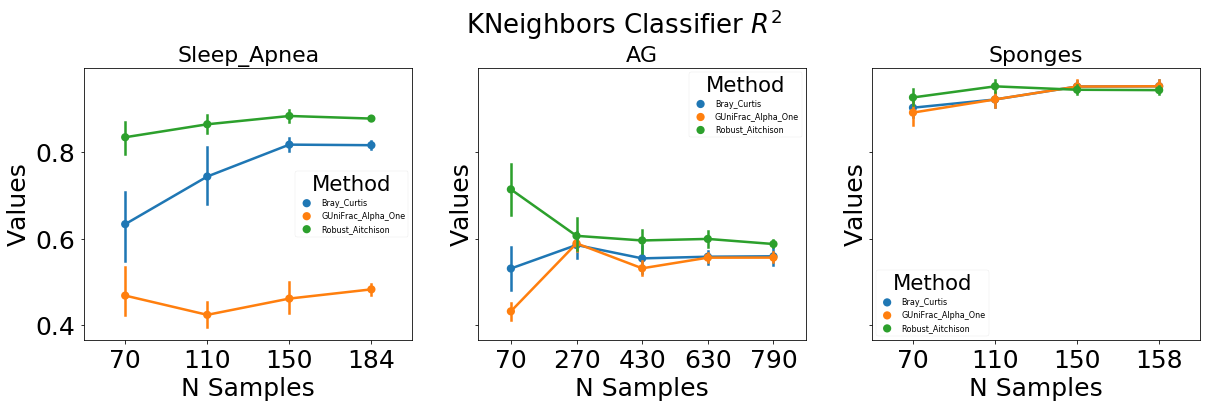

In [31]:
fig,axn=plt.subplots(1,3,figsize=(20,5),sharey=True)

for (dataset_,results_nn),ax_ in zip(both_nn.items(),axn.flat):

    results_nn_plot=pd.DataFrame(results_nn.copy().stack())
    results_nn_plot.reset_index(inplace=True)
    results_nn_plot.columns=['Fold','N Samples','Metric','Method','Values']
    results_nn_plot_=results_nn_plot[results_nn_plot.Metric.isin(['R^{2}'])].copy()
    sns.pointplot(x='N Samples',y='Values',hue='Method',data=results_nn_plot_,ax=ax_)
    ax_.set_title(dataset_,fontsize=22)
plt.suptitle('KNeighbors Classifier $R^{2}$',fontsize=26,y=1.05)
plt.show()


In [38]:
def plot_pcoa(samples, md, ax, factor_, colors_map):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=list(set(md[factor_].values))

    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class
        ax.scatter(samples.loc[idx, 1],
           samples.loc[idx, 0], 
           label=sub_class,
           facecolors=color_,
           edgecolors=color_,
           alpha=.38,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax,cmap_out

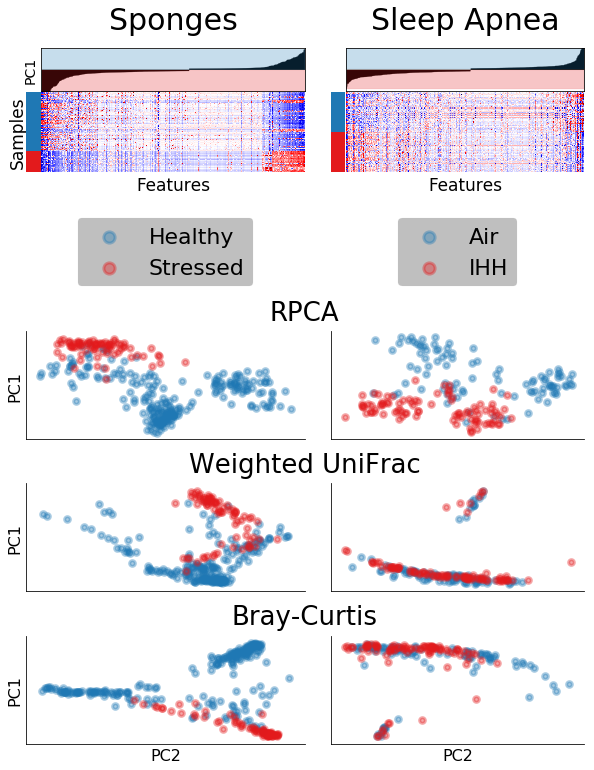

In [47]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


fig = plt.figure(figsize=(10, 13), facecolor='white')
gs = gridspec.GridSpec(130, 55*len(case_study.keys()))
width_start=0
width_end=55
heat_bars=3
colors_map=['#1f78b4','#e31a1c']

for count_,study_ in enumerate(case_study.keys()): 

    ax_map = plt.subplot(gs[8:23, width_start+heat_bars:width_end])
    ax_map_bar = plt.subplot(gs[8:23, width_start:width_start+heat_bars])
    ax_bar = plt.subplot(gs[0:8, width_start+heat_bars:width_end])
    #if count_==len(case_study.keys())-1:
    #    ax_cbar = plt.subplot(gs[8:23, 55*len(case_study.keys())+5:])
    ax_raw_RPCA = plt.subplot(gs[52:72, width_start:width_end])
    ax_raw_WU = plt.subplot(gs[80:100, width_start:width_end])
    ax_raw_BC = plt.subplot(gs[108:128, width_start:width_end])
        
    # plot bar
    feature_loading=case_study[study_]['RPCA_features']
    feature_loading=feature_loading[abs(feature_loading[0])>abs(feature_loading[0]).mean()+.3]
    ind = np.arange(feature_loading.shape[0])
    ax_bar.stackplot(ind, feature_loading[0],color='black',alpha=1)
    ax_bar.set_xlim([0, feature_loading.shape[0]])
    ax_bar.set_ylim([feature_loading[0].min(), feature_loading[0].max()])
    ax_bar.set_xticks([])
    ax_bar.set_ylim([-10, 10])
    ax_bar.grid(which='major', axis='both', linestyle='--')
    if count_==0:
        ax_bar.set_ylabel('PC1', fontsize=14)
    if count_==2:
        ax_bar.set_yticks([])
        #ax_bar.set_ylabel('PC1', fontsize=14)
        #ax_bar.yaxis.set_label_position("right")
    else:
        ax_bar.set_yticks([])
    ax_bar.tick_params(labelsize=8)
    ax_bar.fill_between(ind, 0.1,feature_loading[0].max(), color=colors_map[0],alpha=.25)  
    ax_bar.fill_between(ind, -0.1,feature_loading[0].min(), color=colors_map[1],alpha=.25)  
    ax_bar.set_title(study_.replace('_',' '),fontsize=30,y=1.3)

    # plot map
    table_tmp=case_study[study_]['table'].copy()
    sort_meta=case_study[study_]['metadata'][case_study[study_]['factor']].sort_values()
    sorted_df = table_tmp.reindex(index=sort_meta.index, columns=feature_loading.index)
    sorted_df = sorted_df.loc[:, sorted_df.sum(axis=0) > 10] #make clusters more evident 
    img = ax_map.imshow(clr(centralize(sorted_df+1)), aspect='auto', 
                        norm=MidpointNormalize(midpoint=0.),
                        interpolation='nearest', cmap='seismic')
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    if count_==0:
        ax_map.set_ylabel('Samples', fontsize=17,labelpad=15)
    ax_map.set_xlabel('Features', fontsize=17)
    ax_map.spines['right'].set_visible(False)
    ax_map.spines['top'].set_visible(False)
    ax_map.spines['bottom'].set_visible(False)
    ax_map.spines['left'].set_visible(False)
    ax_map.grid()
    
    # plot RPCA
    _,cmap_out=plot_pcoa(case_study[study_]['RPCA_samples'], 
               case_study[study_]['metadata'], 
               ax_raw_RPCA,case_study[study_]['factor'],colors_map)
    ax_raw_RPCA.legend(loc='upper center', 
                           bbox_to_anchor=(0.5, 2.15),
                           prop={'size':22},
                         fancybox=True, framealpha=0.5,ncol=1
                         , markerscale=2, facecolor="grey")
    
    # color map-bars
    unique_values = sorted(set(sort_meta.values)) 
    colors_map=list(cmap_out.values())
    vmap = { c : i for i, c in enumerate(unique_values) }
    mapper = lambda t: vmap[str(t)]
    cmap_object = mcolors.LinearSegmentedColormap.from_list('custom', colors_map, N=len(colors_map))
    sns.heatmap(pd.DataFrame(sort_meta).applymap(mapper), 
                cmap=cmap_object,ax=ax_map_bar,
                yticklabels=False,xticklabels=False,cbar=False)
    ax_map_bar.set_xlabel('')
    ax_map_bar.set_ylabel('')
    
    # plot WU
    plot_tmp=pcoa(case_study[study_]['Weighted_UniFrac_dist']).samples
    plot_tmp.columns=list(range(len(plot_tmp.columns)))

    plot_pcoa(plot_tmp, 
               case_study[study_]['metadata'], 
               ax_raw_WU,case_study[study_]['factor'],colors_map)
  
    # plot BC
    plot_tmp=pcoa(case_study[study_]['Bray_Curtis_dist']).samples
    plot_tmp.columns=list(range(len(plot_tmp.columns)))

    plot_pcoa(plot_tmp, 
               case_study[study_]['metadata'], 
               ax_raw_BC,case_study[study_]['factor'],colors_map)
    
    if count_==0:
        ax_raw_RPCA.set_ylabel('PC1', fontsize=16)
        ax_raw_WU.set_ylabel('PC1', fontsize=16)
        ax_raw_BC.set_ylabel('PC1', fontsize=16)
    if count_==0:
        ax_raw_RPCA.set_title('RPCA',y=1.05,x=1, fontsize=26)
        ax_raw_WU.set_title('Weighted UniFrac',y=1.05,x=1, fontsize=26)
        ax_raw_BC.set_title('Bray-Curtis',y=1.05,x=1, fontsize=26)        
        
    ax_raw_BC.set_xlabel('PC2', fontsize=16)
    
    # iterate and make new width limits    
    width_start=width_end+5
    width_end+=width_end
    
fig.savefig('figures/figure3.png',dpi=300, bbox_inches='tight',facecolor='white')
plt.show()


## Get taxanomic Differences

In [40]:
def plot_biplot(samples, md, ax, factor_, y_axis_, marker_map=["o","^","s"],cmap_=plt.cm.RdBu):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=list(set(md[factor_].values))
    for sub_class,marker_ in zip(classes,marker_map):
        idx = md[factor_] == sub_class
        ax.scatter(samples.loc[idx, y_axis_],
           samples.loc[idx, 0], 
           label=sub_class,
           c=samples.loc[idx, y_axis_],
           cmap=cmap_,  
           marker=marker_,
           alpha=.9,s=300)     
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.xaxis.set_tick_params(labelsize=20)
    return ax

In [41]:
for count_,study_ in enumerate(case_study.keys()): 
    
    # import data from each study 
    logdf=log_ratios(case_study[study_]['table'].copy(), 
                                 case_study[study_]['metadata'].copy(),
                                 case_study[study_]['RPCA_features'].copy(),
                                 case_study[study_]['RPCA_samples'].copy(),
                                 taxa_tmp=case_study[study_]['taxonomy'].copy())
    case_study[study_]['lr']=logdf


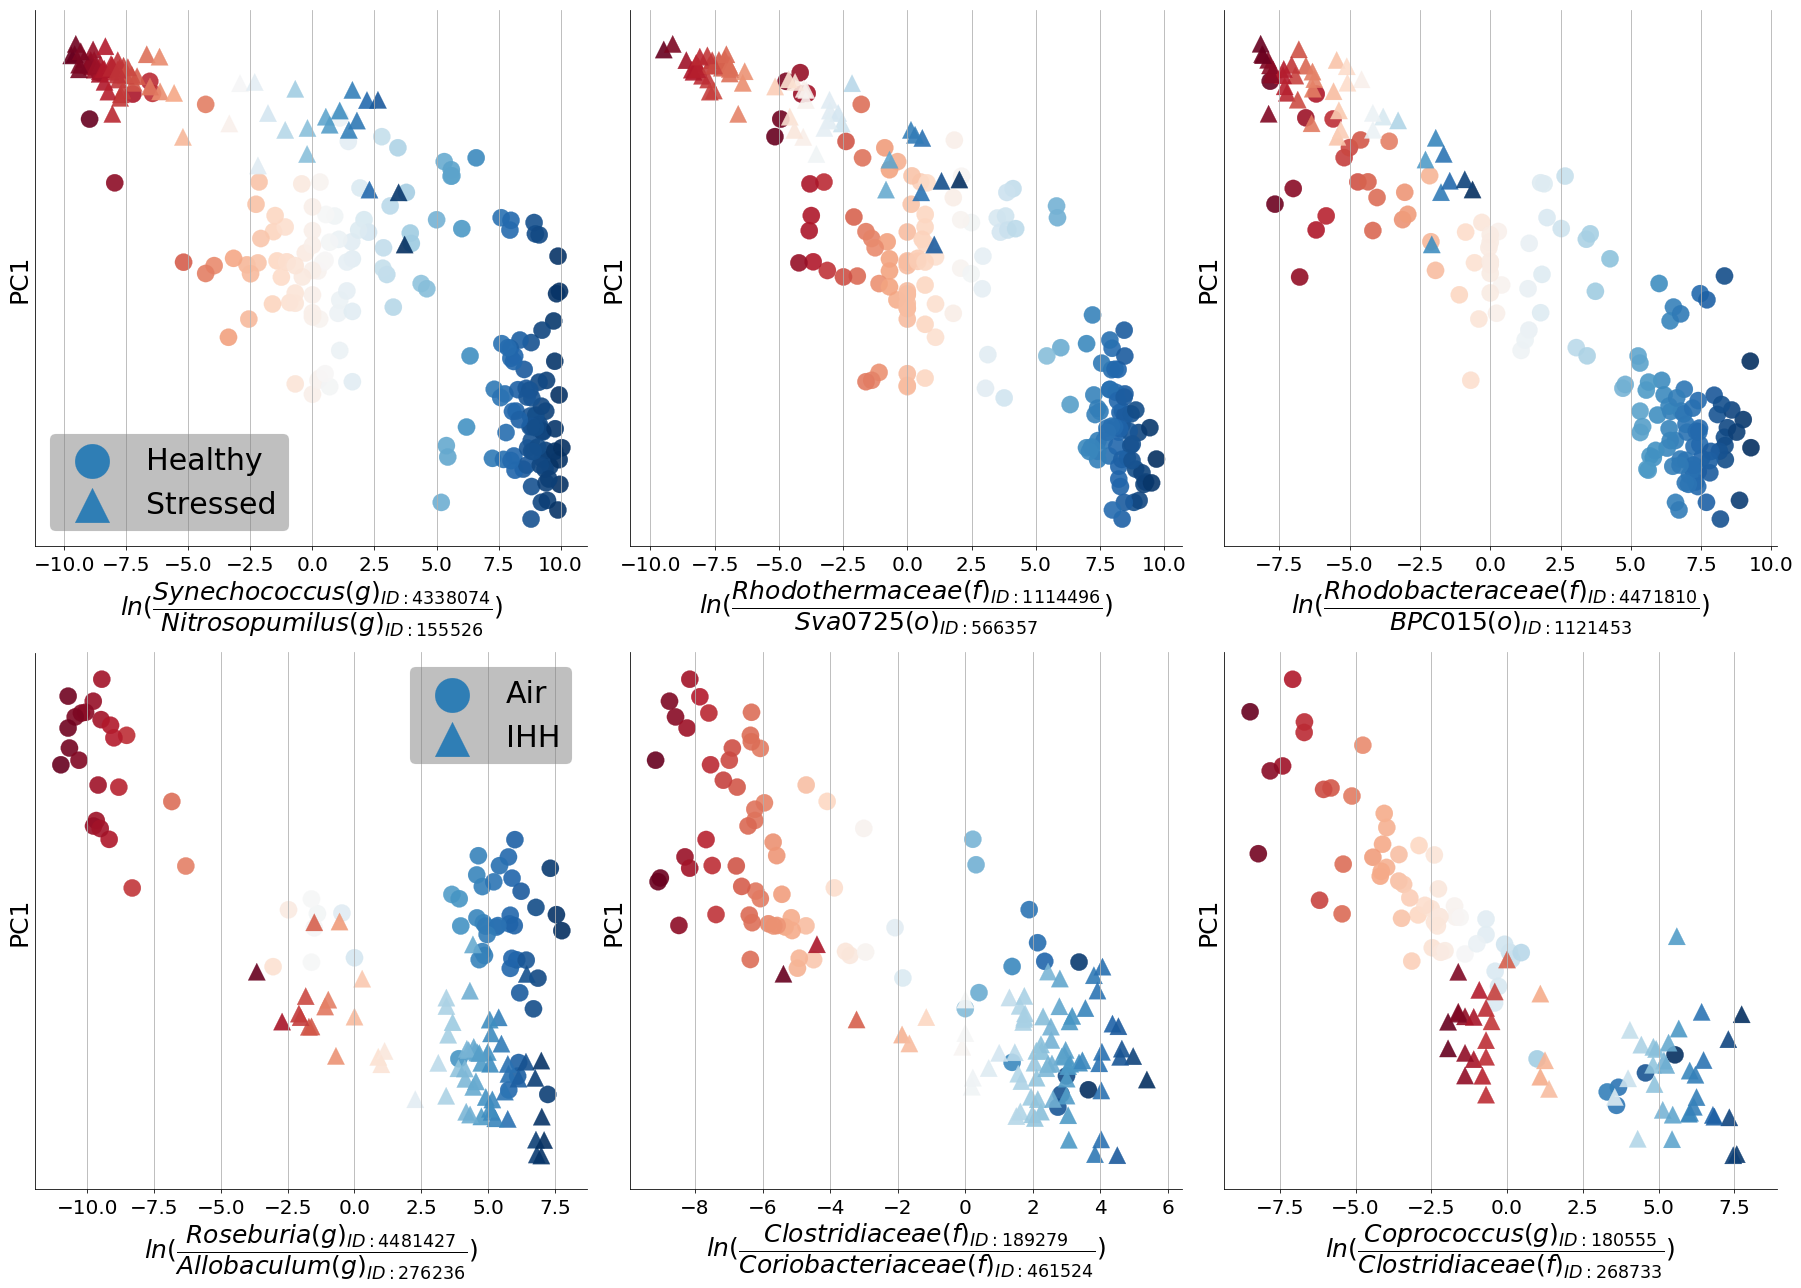

In [42]:
fig,axn=plt.subplots(2,3,figsize=(25,18))
axn=axn.flat
count_=0
for study_ in case_study.keys(): 
    for ratio_ in case_study[study_]['lr'].columns[:3]:
        
        lr_tmp=case_study[study_]['lr'].dropna(subset=[ratio_])
        
        plot_biplot(lr_tmp,  lr_tmp, 
                    axn[count_], case_study[study_]['factor'], ratio_)

        axn[count_].set_xlabel('$'+ratio_+'$',fontsize=25)
        axn[count_].set_ylabel('PC1',fontsize=25)
        if count_ in [0,3,6]:
            axn[count_].legend(loc='best',prop={'size':30},
                         fancybox=True, framealpha=0.5,ncol=1
                         , markerscale=2, facecolor="grey")
        count_+=1
plt.tight_layout()
fig.savefig('figures/figure4.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()
